#  股價預測

## 欲預測內容
### 預測 [標普500指數(^GSPC)](https://finance.yahoo.com/quote/%5EGSPC/)、 股票之一天內之漲跌。


## 安裝欲使用套件

In [2]:
!pip install xgboost
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [10]:
import warnings
warnings.filterwarnings("ignore")

## 輸入資料
* 輸入資料：各股票的開盤價、收盤價、高點、低點、交易量及
 [VIX (VIX)](https://finance.yahoo.com/quote/%5EVIX/)的收盤價做為初步輸入資料
* 欲預測時間：20年

In [22]:
import yfinance as yf
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator


date = datetime.date.today()
today = str(date)
start_years = str(date.today() + relativedelta(years=-20))
stock_list = ['^GSPC', '^VIX']

# 抓取20年資料
gspc = yf.download(stock_list[0], start = start_years, end = today).reset_index().drop(columns='Adj Close')
vix = yf.download(stock_list[1], start = start_years, end = today).reset_index()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [23]:
gspc

,Date,Open,High,Low,Close,Volume
0,2002-11-18,909.830017,915.909973,899.479980,900.359985,1282600000
1,2002-11-19,900.359985,905.450012,893.090027,896.739990,1337400000
2,2002-11-20,896.739990,915.010010,894.929993,914.150024,1517300000
3,2002-11-21,914.150024,935.130005,914.150024,933.760010,2415100000
4,2002-11-22,933.760010,937.280029,928.409973,930.549988,1626800000
...,...,...,...,...,...,...
5029,2022-11-09,3810.939941,3818.199951,3744.219971,3748.570068,4645010000
5030,2022-11-10,3859.889893,3958.330078,3859.889893,3956.370117,5781260000
5031,2022-11-11,3963.719971,4001.479980,3944.820068,3992.929932,5593310000
5032,2022-11-14,3977.969971,4008.969971,3956.399902,3957.250000,4561930000


## 特徵工程 ( For scikit-learn )
* 將當日開盤價、收盤價、高點、低點與前一日的開盤價 1 (True)，0 (False) 去做區分是否有比前一天高

In [24]:
gspc['Vix'] = [ 1 if i > 0 else 0 for i in vix['Close'] - vix['Close'].shift()] # 將 vix 的收盤價一起加入feature
gspc['Label'] = [ 1 if i > 0 else 0 for i in gspc['Close'].shift(-1) - gspc['Close']]
gspc['Open'] = [ 1 if i > 0 else 0 for i in gspc['Open'] - gspc['Open'].shift()]
gspc['Close'] = [ 1 if i > 0 else 0 for i in gspc['Close'] - gspc['Close'].shift()]
gspc['High'] = [ 1 if i > 0 else 0 for i in gspc['High'] - gspc['High'].shift()]
gspc['Low'] = [ 1 if i > 0 else 0 for i in gspc['Low'] - gspc['Low'].shift()]
gspc['Volume'] = [ 1 if i > 0 else 0 for i in gspc['Volume'] - gspc['Volume'].shift()]
gspc = gspc.drop(columns='Date')
gspc = gspc[1:] # 將第一筆資料去除
gspc

,Open,High,Low,Close,Volume,Vix,Label
1,0,0,0,0,1,0,1
2,0,1,1,1,1,0,1
3,1,1,1,1,1,0,0
4,1,1,1,0,0,0,1
5,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...
5029,0,0,0,0,1,1,1
5030,1,1,1,1,1,0,1
5031,1,1,1,1,0,0,0
5032,1,1,1,0,0,1,1


## 切割資料 : 
將資料分為訓練資料集 ( 80% ) 及測試資料集 ( 20 % )

In [25]:
from sklearn.model_selection import train_test_split

train, test = gspc.iloc[:,:-1],gspc.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(train, test,  test_size=0.2, shuffle=False)

## 套入模型
* Xgboost
* RandomForest
* Logistic Regression


使用 confusion matrix 來了解預測結果及實際結果

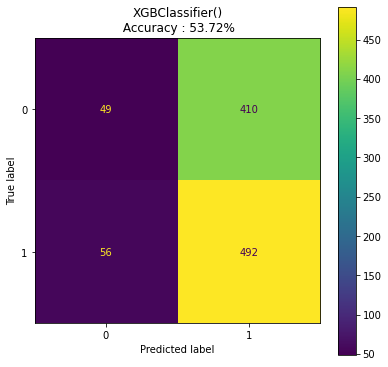

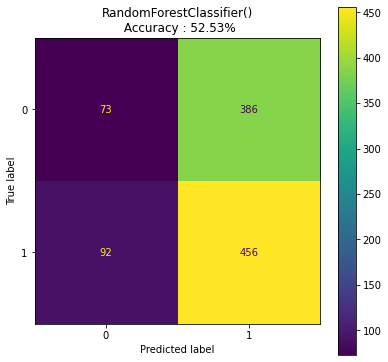

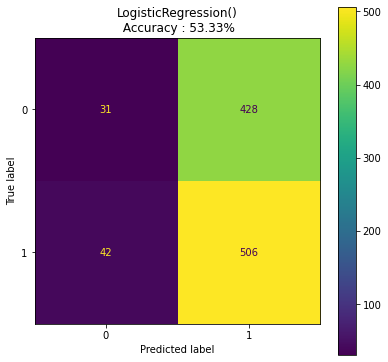

In [30]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

plt.rcParams['figure.figsize']=(6.4,6.4)

xgb = xgb.XGBClassifier()
RF = RandomForestClassifier()
LR = LogisticRegression()

def train_model (model, X_train, y_train, X_test, y_test):
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  Accuracy = metrics.accuracy_score(y_test, pred)
  confusion_matrix = metrics.confusion_matrix(y_test, pred)
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0,1])
  cm_display.plot()
  cm_display.ax_.set_title(str(model) + f'\n Accuracy : {round(Accuracy*100,2)}%')

for model in [xgb, RF, LR]:
  train_model(model, X_train, y_train, X_test, y_test)

# not use

In [ ]:
for days in [1,5,10,20,30,50,60,100,200]:
    days = 30
    for i in range(len(gspc)-days):
        # gspc.loc[i + days ,f'High_Low_{days}'] = (gspc.iloc[i:i+days]['High'].max() - gspc.iloc[i:i+days]['Low'].min()) / gspc.iloc[i+days]['Close']
        # gspc.loc[i + days ,f'High_MA_diff_{days}'] = (gspc.iloc[i+days]['High'] - gspc.iloc[i:i+days]['Close'].mean()) /  gspc.iloc[i+days]['High']
        # gspc.loc[i + days ,f'std_{days}'] = gspc.iloc[i:i+days]['Close'].std()
        # gspc.loc[i + days ,f'MA_{days}'] = gspc.iloc[i:i+days]['Close'].mean()
        gspc.loc[i + days ,f'MA_diff_{days}'] = (gspc.iloc[i+days]['Close'] - gspc.iloc[i:i+days]['Close'].mean()) / gspc.iloc[i+days]['Close']
    #     gspc.loc[i + days ,f'Close_diff_{days}'] = (gspc.iloc[i + days]['Close'] - gspc.iloc[i]['Close']) / gspc.iloc[i + days]['Close']
    #     gspc.loc[i + days ,f'Vol_mean_{days}'] = gspc.iloc[i:i+days]['Volume'].mean()
    #     gspc.loc[i + days ,f'vix_Close_diff_{days}'] = (gspc.iloc[i + days]['vix_Close'] - gspc.iloc[i]['vix_Close']) / gspc.iloc[i+days]['vix_Close']
    #     gspc.loc[i + days ,f'vix_MA_{days}'] = gspc.iloc[i:i+days]['vix_Close'].mean()
    #     gspc.loc[i + days ,f'vix_MA_diff_{days}'] = (gspc.iloc[i+days]['vix_Close'] - gspc.iloc[i:i+days]['vix_Close'].mean()) / gspc.iloc[i+days]['vix_Close']
    # gspc[f'Volume_diff_{days}'] = (gspc['Volume'] - gspc[f'Vol_mean_{days}']) / gspc['Volume']


In [ ]:
days_after = 10
rate = 0.0025

# for i in range(len(gspc)-5):
#     if gspc.iloc[i:i+5]['Label'].sum() >= 4:
#         gspc.loc[i+5, 'five_days_status'] = 1
#     elif gspc.iloc[i:i+5]['Label'].sum() <= 1:
#         gspc.loc[i+5, 'five_days_status'] = -1
#     else:
#         gspc.loc[i+5, 'five_days_status'] = 0

for i in range(len(gspc)-1):
    gspc.loc[i, 'Label'] = 1 if gspc.iloc[i+1]['Close'] > gspc.iloc[i]['Close'] else 0
# for i in range(len(gspc)-days_after):
#     gspc.loc[i, 'variation'] = (gspc.iloc[i+days_after]['Close'] - gspc.iloc[i]['Close']) / gspc.iloc[i]['Close']
#     if (gspc.iloc[i+days_after]['Close'] - gspc.iloc[i]['Close']) /  gspc.iloc[i]['Close']   > rate:
#         gspc.loc[i, 'Label'] = 1 
#     elif (gspc.iloc[i+days_after]['Close'] - gspc.iloc[i]['Close']) / gspc.iloc[i]['Close']   < rate * (-1):
#         gspc.loc[i, 'Label'] = -1
#     else:
#         gspc.loc[i, 'Label'] = 0
        
if 'std_1' in gspc.columns:
    gspc = gspc.drop(columns = 'std_1').dropna()
else:
    gspc = gspc.dropna()
gspc = gspc.reset_index().drop(columns = ['Date','index'])
print('漲: ',len(gspc.loc[gspc['Label'] == 1]), '\n平: ',len(gspc.loc[gspc['Label'] == 0]), '\n跌: ',len(gspc.loc[gspc['Label'] == -1]))

漲:  2319 
平:  1929 
跌:  0


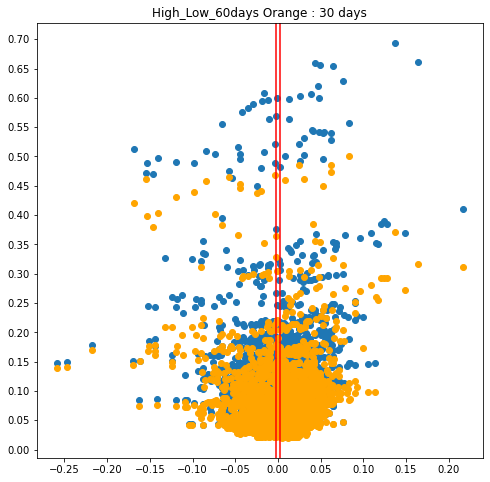

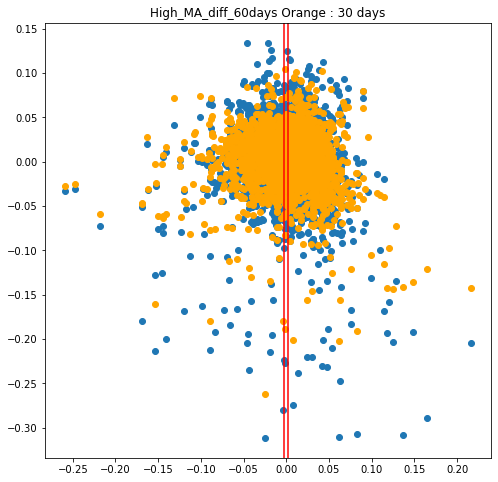

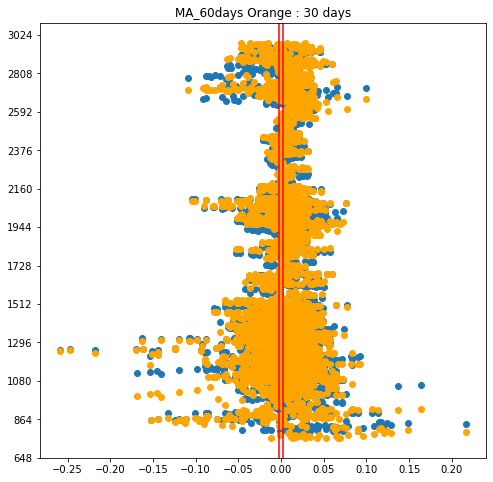

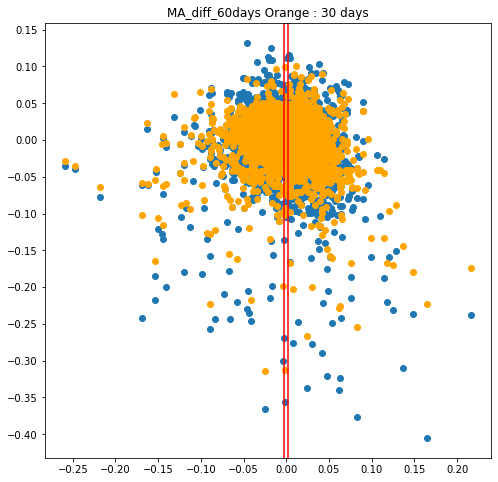

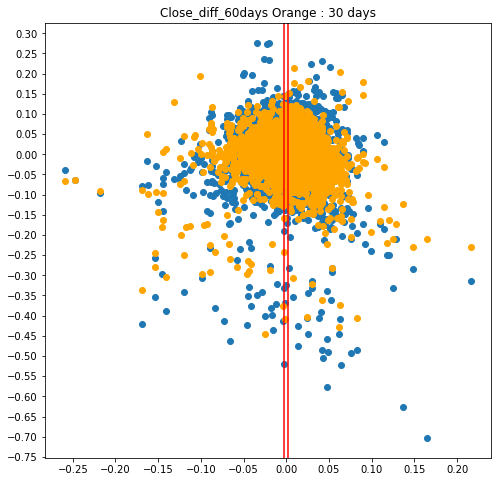

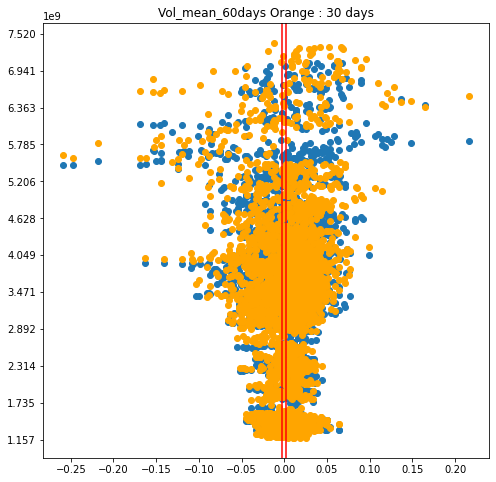

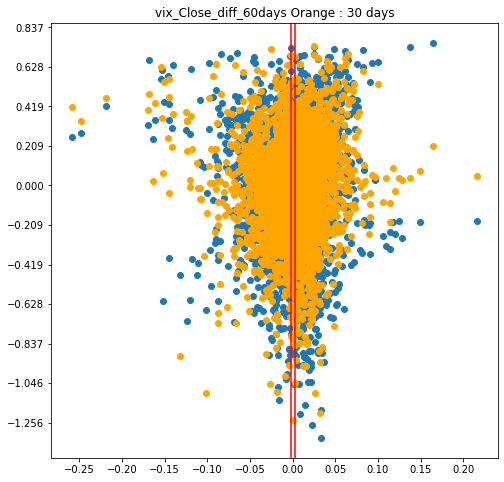

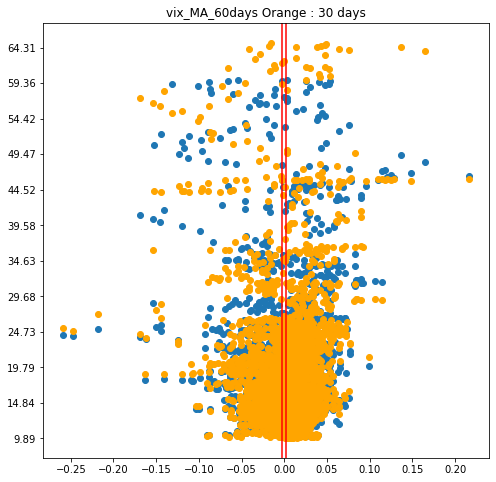

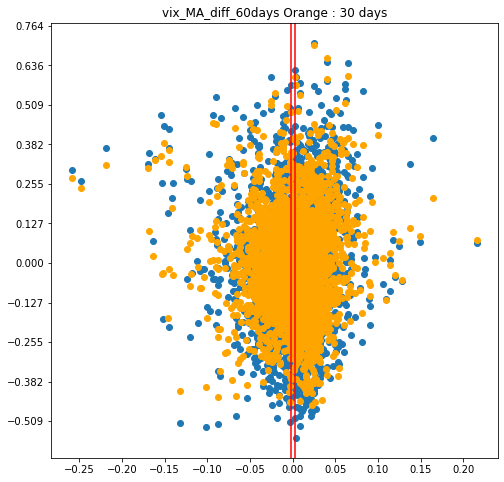

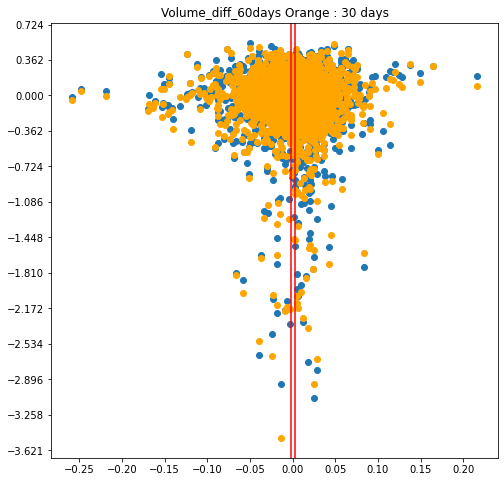

In [ ]:
plt.rcParams['figure.figsize']=(8,8)


test_day = 60
test_day1 = 30
check = 0
for i in [i for i in gspc.columns if  i.endswith(str(test_day)) and 'std' not in i]:
    # y_ = f'vix_Close_diff_{test_day}'
    y_ = i
    y1_ = i.replace(str(test_day),str(test_day1))
    if check == 0:
        x_ = 'variation'
    else:
        x_ = 'Label'

    plt.scatter(gspc[x_], gspc[y_])
    plt.scatter(gspc[x_], gspc[y1_],color = 'Orange')
    if x_ == 'variation':
        plt.axvline(x=rate,color='Red')
        plt.axvline(x=rate*-1,color='Red')

    ax = plt.gca()
    if x_ == 'Label':
        x = MultipleLocator(1)
    elif x_ == 'variation':
        x = MultipleLocator(0.05)
    if gspc[y_].max() - gspc[y_].min() > 1:
        y = MultipleLocator((gspc[y_].max() - gspc[y_].min()) / 10)
    else:
        y = MultipleLocator(0.05)
    ax.xaxis.set_major_locator(x)
    ax.yaxis.set_major_locator(y)
    plt.title(i + f'days Orange : {test_day1} days')
    plt.show()

## 特徵工程
* 將當日開盤價、收盤價、高點、低點與前一日的開盤價、收盤價、高點、低點分別去進行比較，並且以百分比去了解變化量或是 1 (True)，0 (False) 去做區分是否有比前一天高

* 將當日收盤價與前 20、60、600 天平均值去進行比較，並且以百分比去了解變化量或是 1 (True)，0 (False) 去做區分是否有比前 20、60、600 天高

In [ ]:
feature_list = ['Open', 'High', 'Low', 'Close']

# 決定要跟幾天前的資料去做比較
day = 1 

for i in range(len(gspc)):
    
    # 將當日開盤價、收盤價、高點、低點與前一日的開盤價、收盤價、高點、低點分別去進行比較，並且以百分比去了解變化量
    for col1 in feature_list:
        for col2 in feature_list:
            if i < day:
                gspc.loc[i,col1 + '_' + col2] = 0
            else:
                gspc.loc[i,col1 + '_' + col2] = gspc.loc[i,col1] / gspc.loc[max(i-day ,0), col2]
        
    # 將當日收盤價與前 20、60、600 天平均值去進行比較，並且以百分比去了解變化量或是 1 (True)，0 (False) 去做區分是否有比前 20、60、600 天高
    for days in [20, 60, 200]:
        if gspc.loc[i,'Close'] > gspc.loc[max(i - days, 0) : i, col1].mean():
            gspc.loc[i, 'Close_' + str(days)] = 1
        else:
            gspc.loc[i, 'Close_' + str(days)] = 0
            
    # 將兩個收盤價去做比較並加到最後的label
    
    # gspc.loc[i, 'Label'] = 1 if gspc.iloc[i+1]['Close'] > gspc.iloc[i]['Close'] else 0

# 去除幾天前沒有的資料並去除日期時間
if "Date" in gspc.columns:
    gspc = gspc.iloc[day:].drop(columns = 'Date')
gspc

IndexError: single positional indexer is out-of-bounds

## 資料前處理
* 資料拆分為訓練及測試集 ( 8 : 2 )比例
* 資料標準化

In [ ]:
from sklearn.model_selection import train_test_split

# 分開training data 和 testing data ( 8 : 2 ) 並隨機分類
gspc_X, gspc_y = gspc.iloc[:,:-1],gspc.iloc[:,-1]
gspc_X_train, gspc_X_test, gspc_y_train, gspc_y_test = train_test_split(gspc_X, gspc_y, test_size=0.2, random_state=42)


In [ ]:
# 將training data 標準化
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
gspc_X_train = sc.fit_transform(gspc_X_train)
gspc_X_test = sc.transform(gspc_X_test)

TypeError: float() argument must be a string or a number, not 'Timestamp'

In [ ]:
import xgboost as xgb
from matplotlib import pyplot

model = xgb.XGBClassifier()
model.fit(gspc_X_train, gspc_y_train)
x_pred = model.predict(gspc_X_test)

In [ ]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(gspc_y_test, x_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
Accuracy = metrics.accuracy_score(gspc_y_test, x_pred)
Accuracy

## 尋找模型超參數

In [ ]:
# 自定義GridSearchCV
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, # 設定使用的CPU內核(-1意味著我們使用所有可用的CPU內核)
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
        pred = fitted_model.predict_proba(X_test_data)
    else:
        pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [ ]:
# 用GridSearchCV尋找最佳超參數
from sklearn.model_selection import GridSearchCV
import numpy as np
import xgboost as xgb
model = xgb.XGBClassifier()

# 設定要最佳化的參數
param_grid = {
    'booster': ['gbtree'],        # 線性模型   參數說明 : 有兩中模型可以選擇gbtree和gblinear。gbtree使用基於樹的模型進行提升計算，gblinear使用線性模型進行提升計算。預設值為gbtree。
    'objective': ['reg:logistic'],      # 線性迴歸   參數說明 : 指定學習任務和相應的學習目標或要使用的自定義目標函數。
    'n_estimators': [50,70,100,],   #        參數說明 : 梯度提升樹的數量。
    'colsample_bytree': [0.1,0.2,0.3],    #        參數說明 : Subsample ratio of columns when constructing each tree.
    'max_depth': [3,4,5],        #        參數說明 : 最大樹深度。
    'reg_alpha': [0.5,0.7,0.9],     #        參數說明 : L2 正則的懲罰係數。 
    'reg_lambda': [0.5,0.7,0.9],    #        參數說明 : L1 正則的懲罰係數。
    'subsample': [0.3,0.5,0.7]     #        參數說明 : Subsample ratio of the training instance.比率,若將其設置為 0.5 意味著 XGBoost 將在種植樹木之前隨機採樣一半的訓練數據。這將防止過度擬合。子採樣將在每次提升迭代中發生一次。
}

model, pred = algorithm_pipeline(gspc_X_train, gspc_X_test, gspc_y_train, gspc_y_test, model, 
                                 param_grid, cv=5)
# Root Mean Squared Error
print(np.sqrt(-model.best_score_))
print(model.best_params_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
0.022277295967705647
{'booster': 'gbtree', 'colsample_bytree': 0.2, 'max_depth': 3, 'n_estimators': 50, 'objective': 'reg:logistic', 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'subsample': 0.3}


In [ ]:
# 用GridSearchCV尋找最佳超參數
from sklearn.model_selection import GridSearchCV
import numpy as np
import xgboost as xgb
model = xgb.XGBClassifier()

# 設定要最佳化的參數
param_grid = {
    'booster': ['gbtree'],        # 線性模型   參數說明 : 有兩中模型可以選擇gbtree和gblinear。gbtree使用基於樹的模型進行提升計算，gblinear使用線性模型進行提升計算。預設值為gbtree。
    'objective': ['reg:logistic'],      # 線性迴歸   參數說明 : 指定學習任務和相應的學習目標或要使用的自定義目標函數。
    'n_estimators': [10,30,50],   #        參數說明 : 梯度提升樹的數量。
    'colsample_bytree': [0.1,0.2,0.3],    #        參數說明 : Subsample ratio of columns when constructing each tree.
    'max_depth': [4,5,6],        #        參數說明 : 最大樹深度。
    'reg_alpha': [0.1,0.3,0.5],     #        參數說明 : L2 正則的懲罰係數。 
    'reg_lambda': [0.1,0.3,0.5],    #        參數說明 : L1 正則的懲罰係數。
    'subsample': [0.1,0.2,0.3]     #        參數說明 : Subsample ratio of the training instance.比率,若將其設置為 0.5 意味著 XGBoost 將在種植樹木之前隨機採樣一半的訓練數據。這將防止過度擬合。子採樣將在每次提升迭代中發生一次。
}

model, pred = algorithm_pipeline(gspc_X_train, gspc_X_test, gspc_y_train, gspc_y_test, model, 
                                 param_grid, cv=5)
# Root Mean Squared Error
print(np.sqrt(-model.best_score_))
print(model.best_params_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
-0.0
{'booster': 'gbtree', 'colsample_bytree': 0.2, 'max_depth': 5, 'n_estimators': 50, 'objective': 'reg:logistic', 'reg_alpha': 0.1, 'reg_lambda': 0.5, 'subsample': 0.1}
